# <center>公共自行车使用量预测</center> 
首先通过探索性数据分析得出不同城市、时间、工作日/节假日、天气、温度、风速等对自行车使用量的影响，其次通过三种回归模型对测试集建立模型，并进行检验，通过评估方法RMSE(Root of Mean Squared Error)计算分值，分别为27.13，28.19，15.13。说明xgboost回归模型效果最好。

<center>
    
    
## 目录
</center>

#### 一、背景介绍  
 * 1.1数据来源 
 * 1.2数据导入 
 * 1.3数据整理 
 
#### 二、探索性数据分析
 * 2.1不同城市平均使用量  
 * 2.2不同hour使用量  
 * 2.3工作日/节假日自行车使用量  
 * 2.4不同天气自行车使用量  
 * 2.5不同温度下自行车使用量  
 * 2.6不同体感温度下自行车使用量  
 * 2.7不同风速下自行车使用量  
 
#### 三、预测模型  
 + 3.1简单线性回归模型   
 + 3.2决策树回归模型  
 * 3.3xgboost回归模型  

## 一、背景介绍
公共自行车低碳、环保、健康，并且解决了交通中“最后一公里”的痛点，在全国各个城市越来越受欢迎。本练习赛的数据取自于两个城市某街道上的几处公共自行车停车桩。我们希望根据时间、天气等信息，预测出该街区在一小时内的被借取的公共自行车的数量。 

### 1.1数据来源 
Laboratory of Artificial Intelligence and Decision Support (LIAAD), University of Porto, Portugal。为了公平起见，数据已经进行脱敏加工处理。标题图片来源：36氪。 
### 1.2数据导入

In [1]:
# -*- coding: utf-8 -*-
# 导入模块
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import seaborn as sb

# 读取数据
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
submit = pd.read_csv("./data/sample_submit.csv")

In [2]:
train.head()

,id,city,hour,is_workday,weather,temp_1,temp_2,wind,y
0,1,0,22,1,2,3.0,0.7,0,15
1,2,0,10,1,1,21.0,24.9,3,48
2,3,0,0,1,1,25.3,27.4,0,21
3,4,0,7,0,1,15.7,16.2,0,11
4,5,1,10,1,1,21.1,25.0,2,39


In [3]:
train.describe()

,id,city,hour,is_workday,weather,temp_1,temp_2,wind,y
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,0.499800,11.527500,0.684000,1.42750,15.268190,15.321230,1.248600,50.537400
std,2886.89568,0.500025,6.909777,0.464936,0.63764,9.029152,11.308986,1.095773,47.769645
min,1.00000,0.000000,0.000000,0.000000,1.00000,-7.600000,-15.600000,0.000000,0.000000
25%,2500.75000,0.000000,6.000000,0.000000,1.00000,7.800000,5.800000,0.000000,10.000000
50%,5000.50000,0.000000,12.000000,1.000000,1.00000,15.600000,16.000000,1.000000,39.000000
75%,7500.25000,1.000000,18.000000,1.000000,2.00000,22.600000,24.800000,2.000000,75.000000
max,10000.00000,1.000000,23.000000,1.000000,4.00000,38.600000,46.800000,7.000000,249.000000


通过train数据可以看出，共有10000条记录，city0和city1数据记录各占一半，hour平均分布，工作日占比为68.4%，实际温度范围-7.7至38.6℃，平均实际温度15.26℃，因此可以猜测两城市均为北方城市，体感温度范围-15.6至46.8℃，平均实际温度15.3℃，风速范围0-7，大风天气不多，平均风速1.25m/s，自行车租借范围0-249辆，租借平均数50辆左右，租借中位数为39辆。

### 1.3数据整理

In [4]:
#删除id列
train.drop('id',axis=1, inplace = True)
test.drop('id',axis=1, inplace = True)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
city          10000 non-null int64
hour          10000 non-null int64
is_workday    10000 non-null int64
weather       10000 non-null int64
temp_1        10000 non-null float64
temp_2        10000 non-null float64
wind          10000 non-null int64
y             10000 non-null int64
dtypes: float64(2), int64(6)
memory usage: 625.1 KB


没有数据缺失情况,部分数据应为分类数据类型，而实际为整型，不影响分析，可不处理。

In [6]:
corr = train.corr()
corr[np.abs(corr)<0.2] =np.nan
corr #相关系数

,city,hour,is_workday,weather,temp_1,temp_2,wind,y
city,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hour,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.406489
is_workday,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
weather,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
temp_1,NaN,NaN,NaN,NaN,1.000000,0.987357,NaN,0.417115
temp_2,NaN,NaN,NaN,NaN,0.987357,1.000000,NaN,0.413942
wind,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
y,NaN,0.406489,NaN,NaN,0.417115,0.413942,NaN,1.000000


从相关性可以看出，用车时间和当时气温对自行车使用量y有较强关系；气温和体感温度显强正相关（共线性），这个和常识一致。

## 二、探索性数据分析

### 2.1不同城市平均使用量

D:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


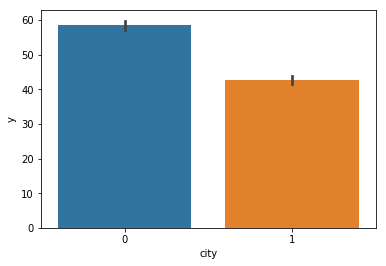

In [7]:
sb.barplot(data = train, x='city', y= 'y');

城市0使用量高于城市1。

### 2.2不同hour使用量

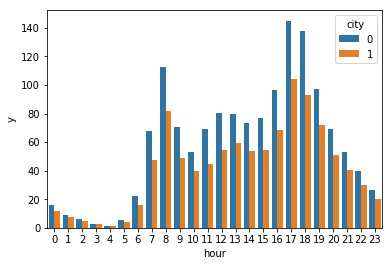

In [8]:
base_color = sb.color_palette()[0]
sb.barplot(data = train, x='hour', y= 'y', hue='city',ci=None);

自行车使用量在全天呈现明显趋势：

分为早高峰（8时）和晚高峰（17-18时），晚高峰达到120辆左右，高于早高峰的10辆；  
晚高峰后使用量逐渐下降，在凌晨4时达到最小值。  
早高峰上升过程比晚高峰结束过程更陡，说明相比下班回家时，早晨上班时间更急迫。

### 2.3工作日/节假日自行车使用量

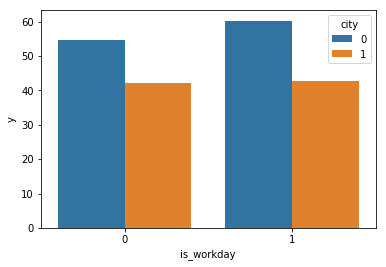

In [9]:
sb.barplot(data = train, x='is_workday', y= 'y', hue='city',ci=None);

可以看出，只对城市0有一些影响，但影响不大。

### 2.4不同天气自行车使用量

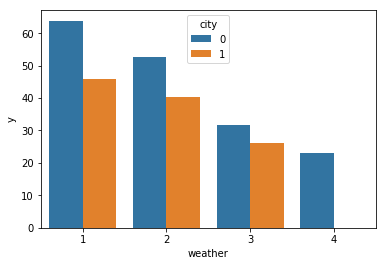

In [10]:
sb.barplot(data = train, x='weather', y= 'y', hue='city',ci=None);

从晴好天气、阴天、降雨、强降雨的天气逐渐恶劣的情况下，自行车使用量逐渐下降。在强降雨天气，城市1已经无人租车。

### 2.5不同温度下自行车使用量

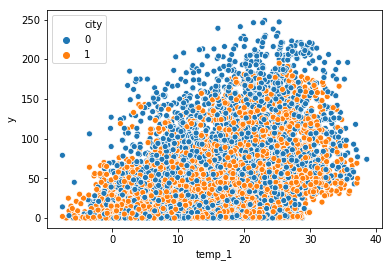

In [11]:
sb.scatterplot(data = train, x='temp_1', y= 'y', hue='city',ci=None);

温度与使用量呈现线性关系。

### 2.6不同体感温度下自行车使用量

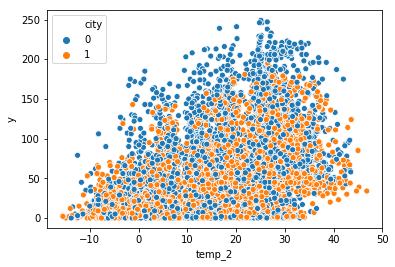

In [12]:
sb.scatterplot(data = train, x='temp_2', y= 'y', hue='city',ci=None);

温度与使用量呈现线性关系。

### 2.7不同风速下自行车使用量

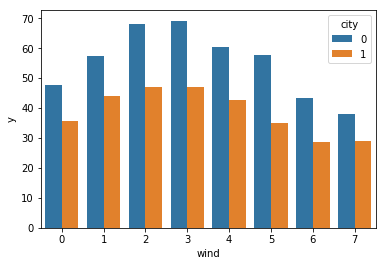

In [13]:
sb.barplot(data = train, x='wind', y= 'y', hue='city',ci=None);

风速适中时（2m/s-3m/s），自行车使用量最大。

## 三、预测模型

由于城市、时间、气温、天气状况、风速五个变量对使用量影响较大，所以以此作为特征变量拟合模型。
### 3.1简单线性回归模型

In [14]:
#数据预处理
#将城市、小时、天气状况、风速等进行哑变量变换
dummy_city = pd.get_dummies(train['city'],prefix='city')
dummy_hour = pd.get_dummies(train['hour'],prefix='hour')
dummy_weather = pd.get_dummies(train['weather'],prefix='weather')
dummy_wind = pd.get_dummies(train['wind'],prefix='wind')
#数据合并
x = pd.concat([dummy_city, dummy_hour, dummy_weather, dummy_wind], axis = 1)
x['temp_1'] =train['temp_1']
y=train['y']
#拆分数据集
from sklearn.cross_validation import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=5)
#线性回归
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(x_train,y_train)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
y_pred = linreg.predict(x_test)
y_pred

array([ 8.5     , 51.796875, 84.640625, ..., 42.15625 , -2.734375,
        5.8125  ])

In [16]:
# 若预测值是负数，则取0
y_pred = map(lambda x: x if x >= 0 else 0, y_pred)
y_pred= list(y_pred)

In [17]:
def score(y_pred,y_test):
    return np.sqrt(sum((np.array(y_test) - np.array(y_pred))**2)/len(y_pred))

In [18]:
score(y_pred,y_test)

27.13020951918152

**简单线性回归模型得分27.13。**

In [19]:
#更具test的7000数据，得到测试结果

dummy_city = pd.get_dummies(test['city'],prefix='city')
dummy_hour = pd.get_dummies(test['hour'],prefix='hour')
dummy_weather = pd.get_dummies(test['weather'],prefix='weather')
dummy_wind = pd.get_dummies(test['wind'],prefix='wind')
x_test_out = pd.concat([dummy_city, dummy_hour, dummy_weather, dummy_wind], axis = 1)
x_test_out['temp_1'] =test['temp_1']
y_pred = linreg.predict(x_test_out)
# 若预测值是负数，则取0
y_pred = list(map(lambda x: x if x >= 0 else 0, y_pred))
# 输出预测结果至my_LR_prediction.csv
submit['y'] = y_pred
submit.to_csv('my_LR_prediction.csv', index=False)
submit.head(2)

,id,y
0,10001,29.312500
1,10002,135.171875


### 3.2决策树回归模型

In [20]:
#决策树不需要变量变为哑变量
x = train.drop('y',axis = 1)
y = train['y']

In [21]:
x.shape,y.shape

((10000, 7), (10000,))

In [22]:
#拆分数据集
from sklearn.cross_validation import train_test_split
#cross_validation.train_test_split(train_data,train_target,test_size=0.4, random_state=0)
# 避免过拟合，采用交叉验证，验证集占训练集20%，固定随机种子（random_state)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state=5)

In [23]:
# 决策树
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
 
# 建立最大深度为5的决策树回归模型
reg = DecisionTreeRegressor(max_depth=5)
reg.fit(x_train, y_train)

y_pred = reg.predict(x_test)

#计算RMSE值
print(np.sqrt(sum((np.array(y_test) - np.array(y_pred))**2)/len(y_pred)))

28.192154530848544


**决策树回归模型得分28.19。**

### 3.3xgboost回归模型

In [24]:
#决策树不需要变量变为哑变量
x = train.drop('y',axis = 1)
y = train['y']

In [25]:
#拆分数据集
from sklearn.cross_validation import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=5)

In [26]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((7500, 7), (2500, 7), (7500,), (2500,))

In [27]:
from xgboost import XGBRegressor
import pandas as pd
 
# 建立一个默认的xgboost回归模型
reg = XGBRegressor(learning_rate = 0.05,max_depth = 5,n_estimators = 500)
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
#计算RMSE值
print(np.sqrt(sum((np.array(y_test) - np.array(y_pred))**2)/len(y_pred)))

15.2293351137216


**xgboost回归模型得分15.23。**

In [28]:
test = pd.read_csv("./data/test.csv")

In [29]:
test.drop('id', axis=1, inplace= True)

In [30]:
test.shape

(7000, 7)

In [31]:
y_pred = reg.predict(test)
# 若预测值是负数，则取0
y_pred = list(map(lambda x: x if x >= 0 else 0, y_pred))
# 输出预测结果至my_LR_prediction.csv
submit['y'] = y_pred
submit.to_csv('my_LR_prediction.csv', index=False)
submit.head(2)

,id,y
0,10001,6.074973
1,10002,86.305092


上传到[http://sofasofa.io](http://sofasofa.io)，排名更新后，可以看到RMSE=15.515排名94。

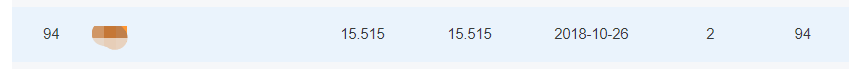

|排序|姓名|分数|最高分数|日期|提交次数|历史最高排名|
|----|---|-----|-------|:----:| --------|-----------|
|94|evan|15.15|15.15|2018-10-26|2|94|